In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import modules and utilities

In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/opinion-lab-group-2.3/refactorization'
%pwd 

/content/drive/My Drive/Colab Notebooks/opinion-lab-group-2.3/refactorization


'/content/drive/My Drive/Colab Notebooks/opinion-lab-group-2.3/refactorization'

In [3]:
from collections import Counter 
import json

import numpy as np
from util import DocType, Polarity, Source, OptimalKClustersConfig
from radarfactory import radar_factory, show_simple_radar_chart

from timeseriesplot import get_sentences_counts, get_simple_timeseries_plot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Print configuration for optimal k

In [4]:
print('Original number of clusters', OptimalKClustersConfig.k_with_garbage)
print()
print('Desired number of clusters:', OptimalKClustersConfig.k)
print('Desired {} clusters:'.format(OptimalKClustersConfig.k))
OptimalKClustersConfig.clusters

Original number of clusters 15

Desired number of clusters: 11
Desired 11 clusters:


['Planting and gardening',
 'Retail',
 'GMO label and bio-products',
 'Taste and food',
 'Chemicals and cancer',
 'Genetic research',
 'Health and diet',
 'Governance and public policy',
 'Meat and animal feeding',
 'Agriculture',
 'Price and consumption']

# Import dictionary of sentence cluster and sentiment assignments


Format of the assignment dictionary: <br/>
```
[{"global_id": 0, "corpus_name": "nytimes", "doc_id": 0, "com_id": -1, "date": "2005-11-01", "cluster": 1, "sentiment": 0.125}, 
 {"global_id": 1, "corpus_name": "nytimes", "doc_id": 0, "com_id": -1, "date": "2005-11-01", "cluster": 1, "sentiment": -0.125},
  ...,
 {"global_id": 77023, "corpus_name": "quora", "doc_id": 0, "com_id": 0, "date": "2017-10-11", "cluster": 9, "sentiment": 0.125},
  ...,
 {"global_id": 136425, "corpus_name": "spiegel", "doc_id": 0, "com_id": -1, "date": "2014-01-27", "cluster": 10, "sentiment": -0.5217333333333333}
  ...]
```




In [5]:
path = '/content/drive/My Drive/Colab Notebooks/opinion-lab-group-2.3/refactorization/data/sentence_cluster_sentiment_dict.json'

with open(path, 'r') as f:
  assignments = json.load(f)

print('Loaded total {} cluster-sentiment assignments'.format(len(assignments)))
print('Example of an assignment object')
assignments[0]

Loaded total 328091 cluster-sentiment assignments
Example of an assignment object


{'cluster': 1,
 'com_id': -1,
 'corpus_name': 'nytimes',
 'date': '2005-11-01',
 'doc_id': 0,
 'global_id': 0,
 'sentiment': 0.125}

In [6]:
def get_average_cluster_distribution_in_percentage(assignments: dict, with_garbage_clusters = False):
  if not with_garbage_clusters:
    assignments = [a for a in assignments if a['cluster'] not in OptimalKClustersConfig.garbage_clusters]

  grouped_assignments = []
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.NYTIMES and a['com_id'] == DocType.NON_COMMENT.value])
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.NYTIMES and a['com_id'] != DocType.NON_COMMENT.value])
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.QUORA and a['com_id'] == DocType.NON_COMMENT.value])
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.QUORA and a['com_id'] != DocType.NON_COMMENT.value])
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.SPEIGEL and a['com_id'] == DocType.NON_COMMENT.value])
  grouped_assignments.append([a for a in assignments if a['corpus_name'] == Source.SPEIGEL and a['com_id'] != DocType.NON_COMMENT.value])

  totals = []
  distribution = []
  for ga in grouped_assignments:
    total = len(ga)
    totals.append(total)

    tuples = []
    for a in ga:
      tuples.append((a['cluster']))

    tuples = sorted(tuples, key = lambda item: item)
    counts = Counter(tuples, )

    array = np.zeros((OptimalKClustersConfig.k_with_garbage))
    for item, count in counts.items():
      array[item] = count / total * 100

    # print(array)
    distribution.append(array)
  
  distribution = np.array(distribution)
  if not with_garbage_clusters:
    distribution = np.delete(distribution, OptimalKClustersConfig.garbage_clusters, axis = 1)
  return totals, distribution

# Plots and interpretations

New York Times - article: total 14202 sentences
New York Times - comment: total 45597 sentences
Quora - article: total 1022 sentences
Quora - comment: total 43118 sentences
Der Spiegel - article: total 6795 sentences
Der Spiegel - comment: total 121369 sentences



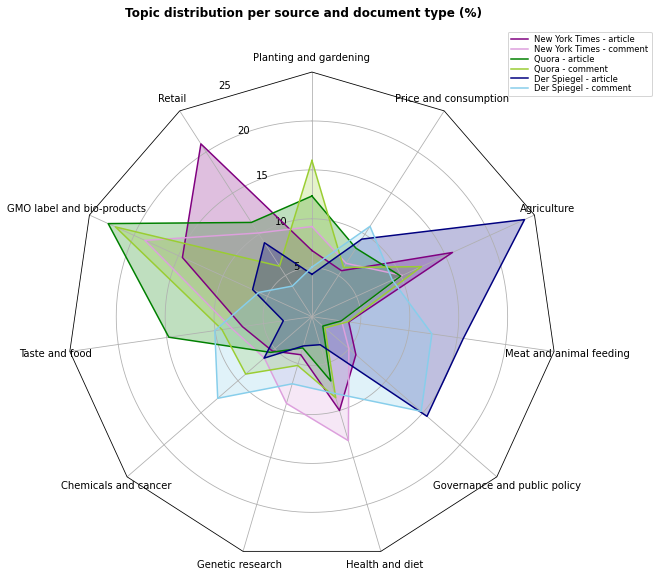

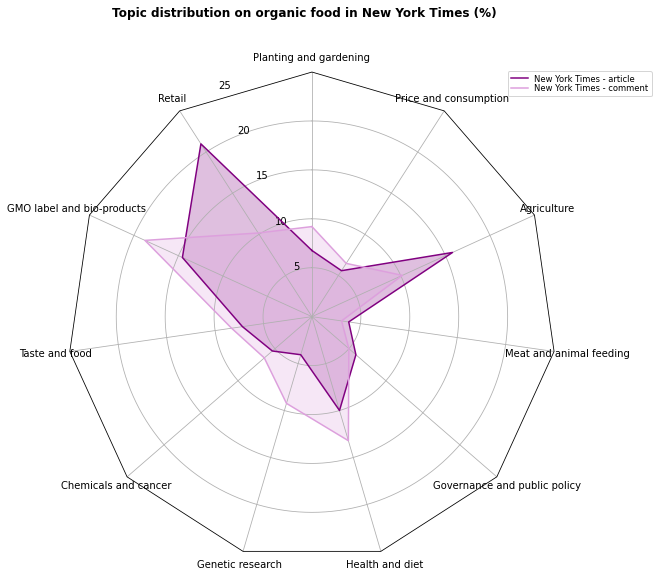

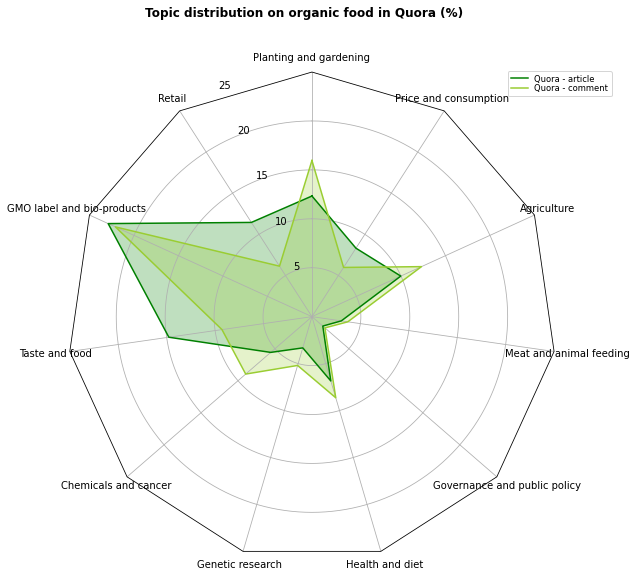

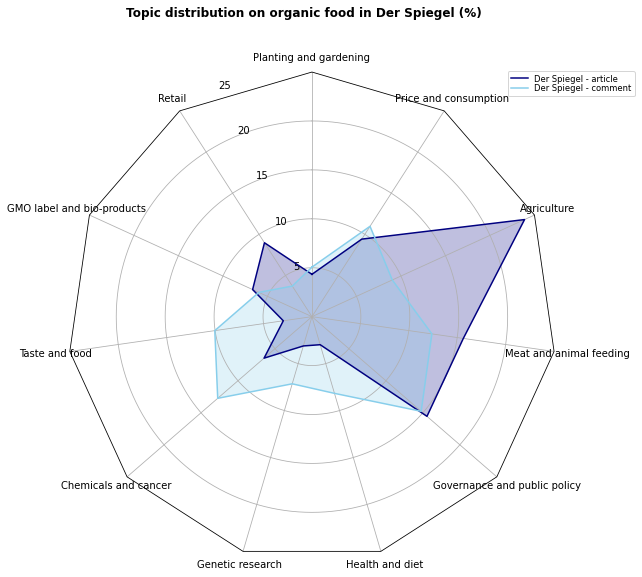

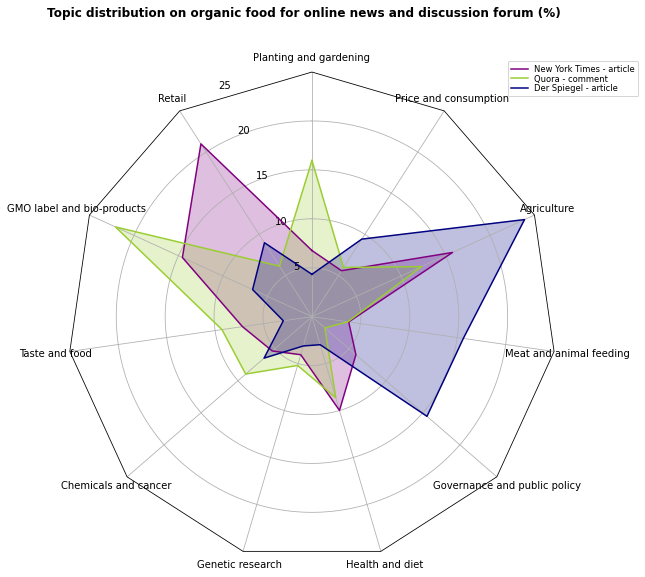

In [7]:
title = 'Topic distribution per source and document type (%)'
colors = ['purple', 'plum', 'green', 'yellowgreen', 'navy', 'skyblue']
labels = ('New York Times - article', 'New York Times - comment', 'Quora - article', 'Quora - comment', 'Der Spiegel - article', 'Der Spiegel - comment')
totals, data = get_average_cluster_distribution_in_percentage(assignments)

for i in range(len(labels)):
  print('{}: total {} sentences'.format(labels[i], totals[i]))
print()

show_simple_radar_chart(OptimalKClustersConfig.clusters, data, colors, labels, title)
show_simple_radar_chart(OptimalKClustersConfig.clusters, data[0:2], colors[0:2], labels[0:2], 'Topic distribution on organic food in New York Times (%)')
show_simple_radar_chart(OptimalKClustersConfig.clusters, data[2:4], colors[2:4], labels[2:4], 'Topic distribution on organic food in Quora (%)')
show_simple_radar_chart(OptimalKClustersConfig.clusters, data[4:6], colors[4:6], labels[4:6], 'Topic distribution on organic food in Der Spiegel (%)')
show_simple_radar_chart(OptimalKClustersConfig.clusters, data[[0, 3, 4], :], [colors[0], colors[3], colors[4]], [labels[0], labels[3], labels[4]], 'Topic distribution on organic food for online news and discussion forum (%)')

 

# Plots with timelines

In [27]:
import matplotlib.pyplot as plt

def get_simple_timeseries_plot(source: str, timeseries: list, y_articles: np.array, y_comments: np.array, colors = ['purple', 'plum'], ymax = 50, figsize = (16, 8), title_fontsize = 20, label_fontsize = 12, xticks = None):
  for i in range(OptimalKClustersConfig.k_with_garbage): 
    if i not in OptimalKClustersConfig.garbage_clusters:
      # plot
      # plt.plot(timeseries, cluster0_nytimes_article)
      # plt.plot(timeseries, cluster0_nytimes_comment)
      plt.figure(figsize = figsize)
      plt.title(OptimalKClustersConfig.clusters_with_garbage[i], fontsize = title_fontsize)
      plt.ylim(0, ymax)
      plt.ylabel('Precentage(%) in occurrences', fontsize = label_fontsize)
      plt.xlabel('Months', fontsize = label_fontsize)
      plt.plot(timeseries, y_articles[i] / sum(y_articles[i]) * 100, label = 'sentences in news', color = colors[0])
      # plt.fill(timeseries, y_articles[i] / sum(y_articles[i]) * 100, facecolor = colors[0], alpha = 0.25)
      plt.plot(timeseries, y_comments[i] / sum(y_comments[i]) * 100, label = "sentences in readers' comments", color = colors[1])
      # plt.fill(timeseries, y_comments[i] / sum(y_comments[i]) * 100, facecolor = colors[1], alpha = 0.25)
      
      if xticks is not None:
      	plt.xticks(xticks)
      plt.legend(fontsize = 15)
      # beautify the x-labels
      plt.gcf().autofmt_xdate()
      
      plt.show()

During 2007-01-01 to 2017-12-31
Number of senteces for New York Times articles: 11384
Number of senteces for New York Times comments: 55481
Number of senteces for Quora articles: 1269
Number of senteces for Quora comments: 53111
Number of senteces for Der Spiegel articles: 8189
Number of senteces for Der Spiegel comments: 192438
For New York Times:


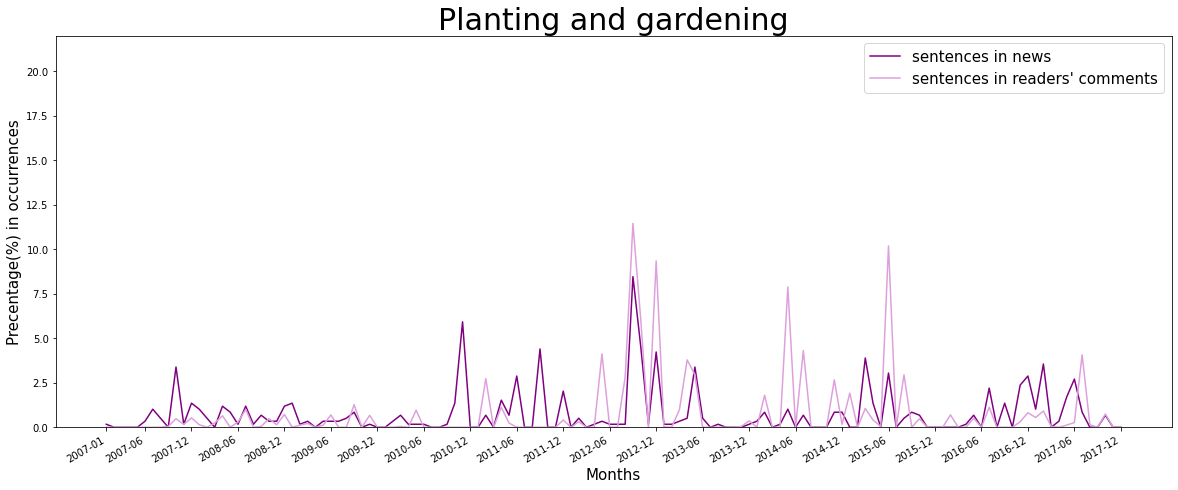

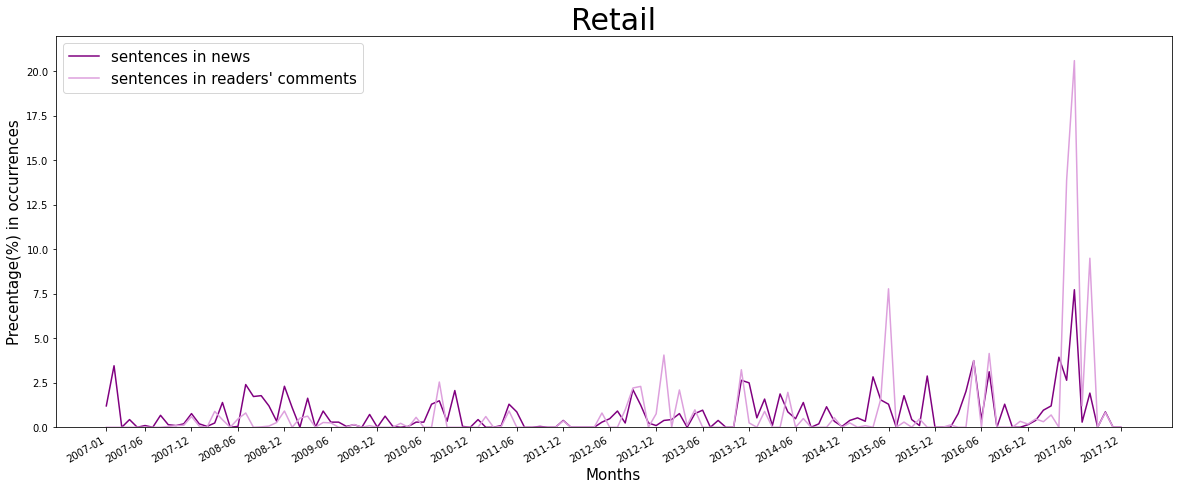

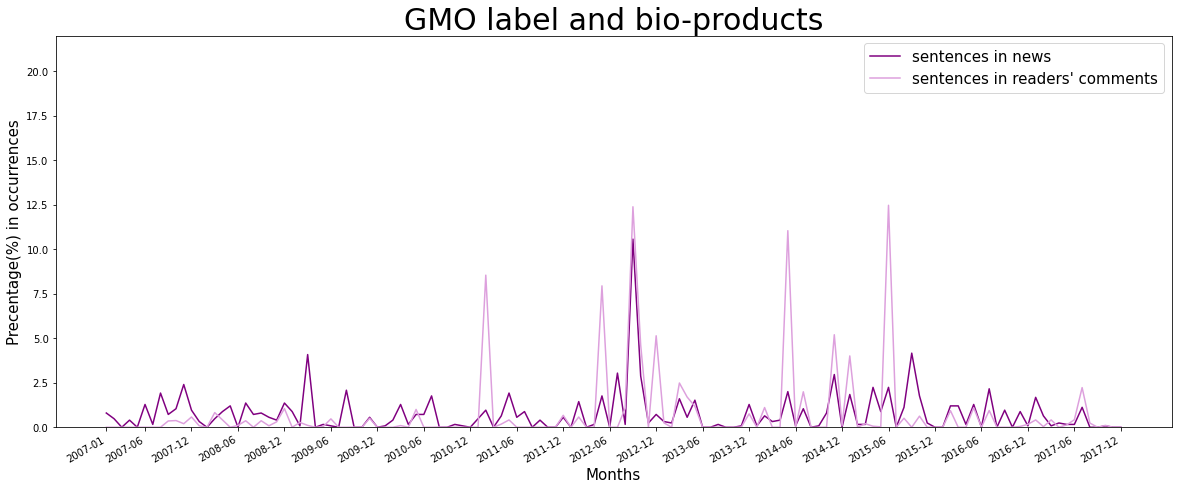

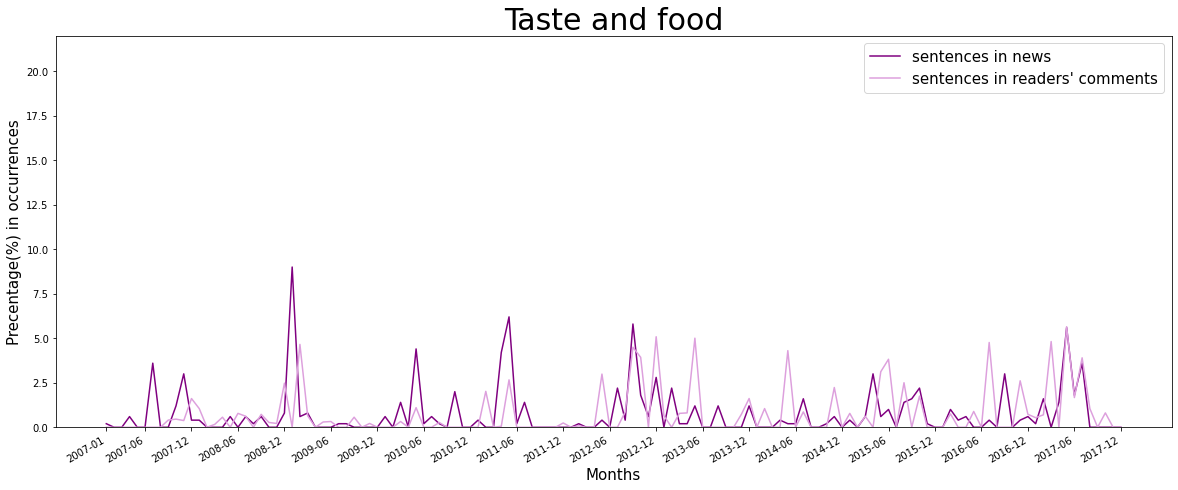

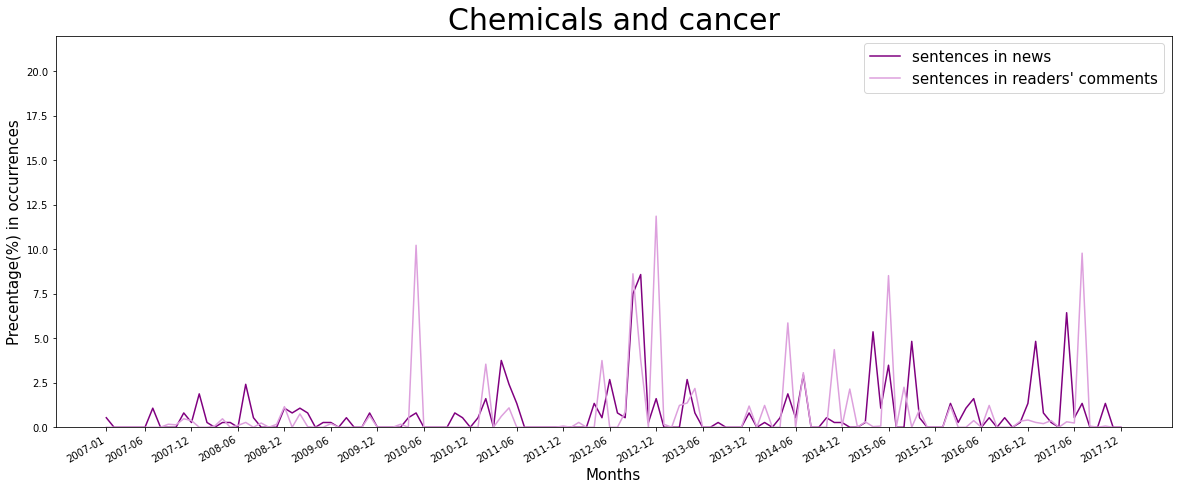

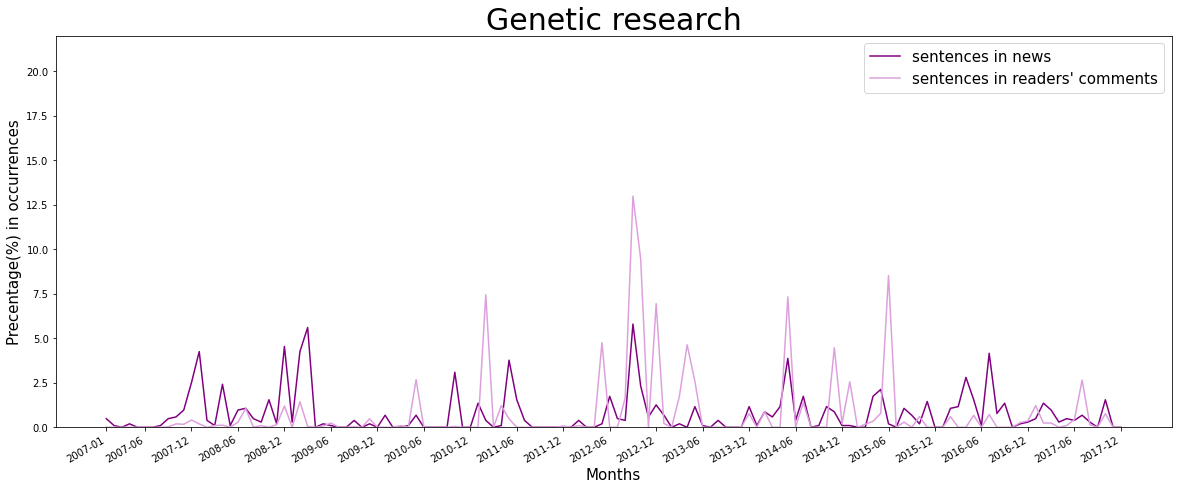

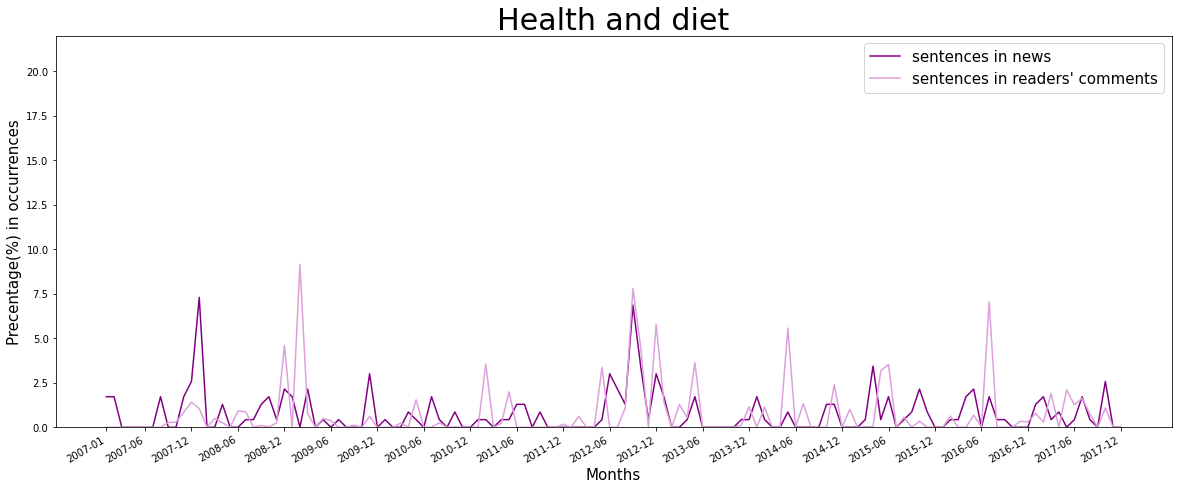

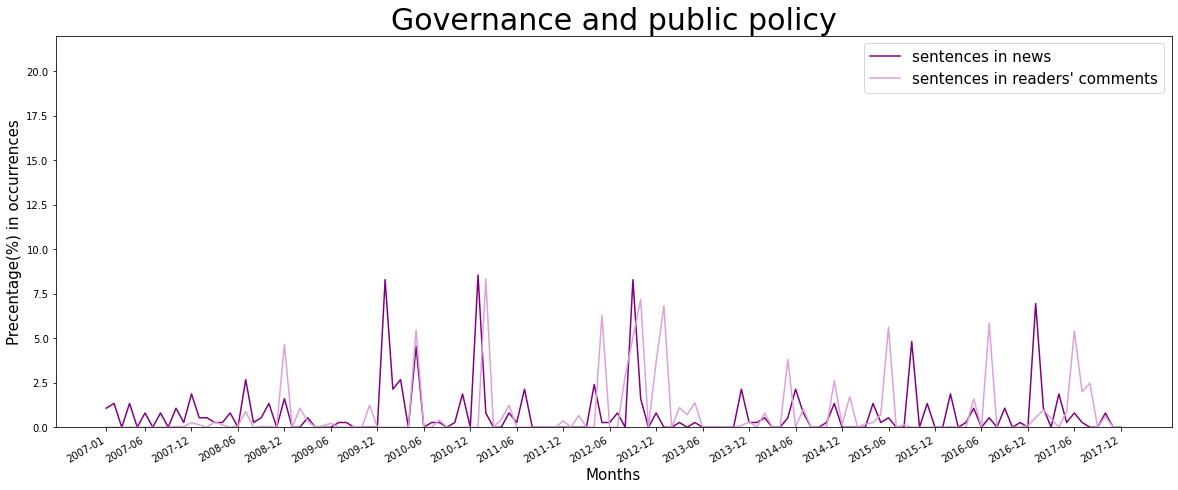

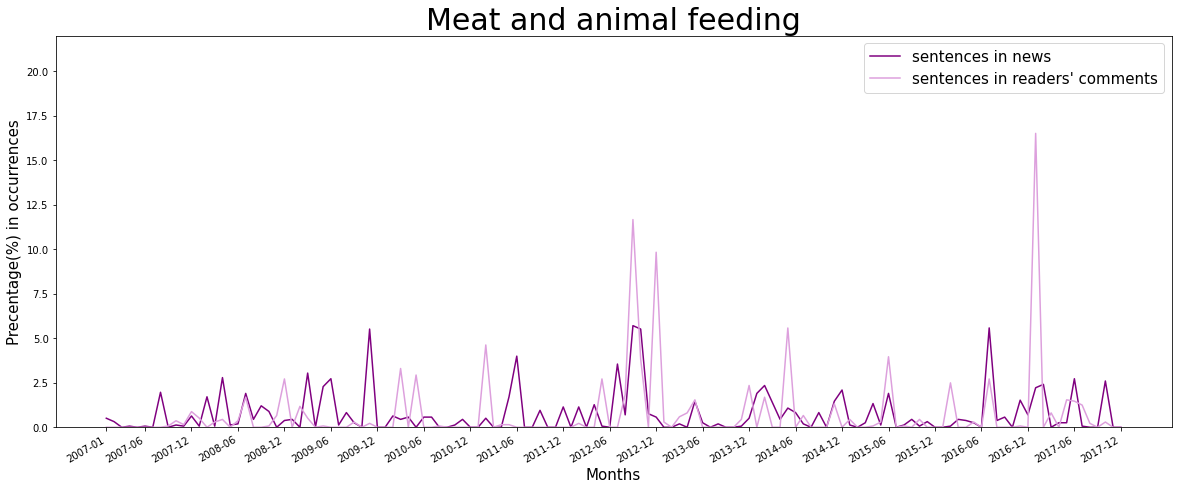

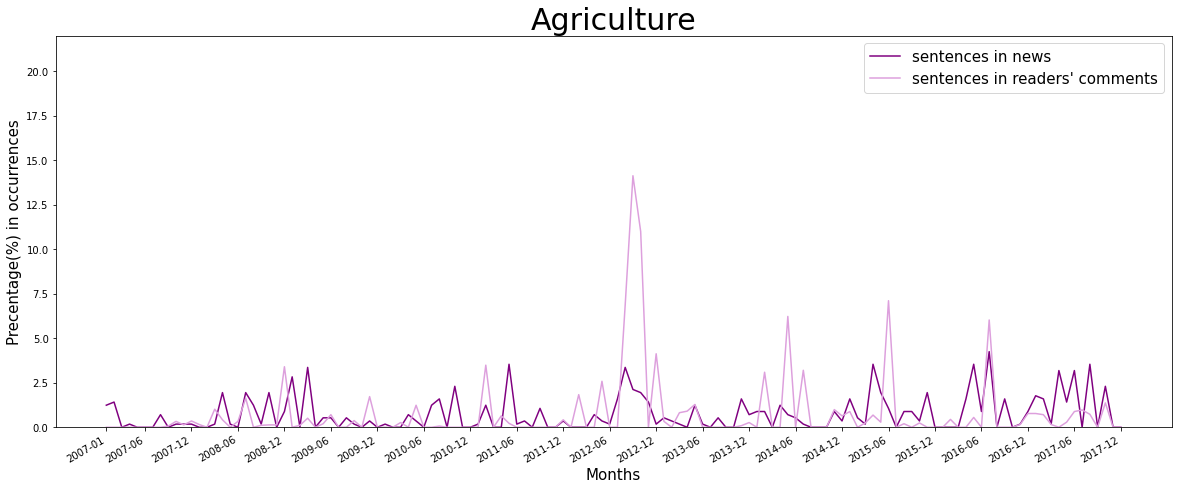

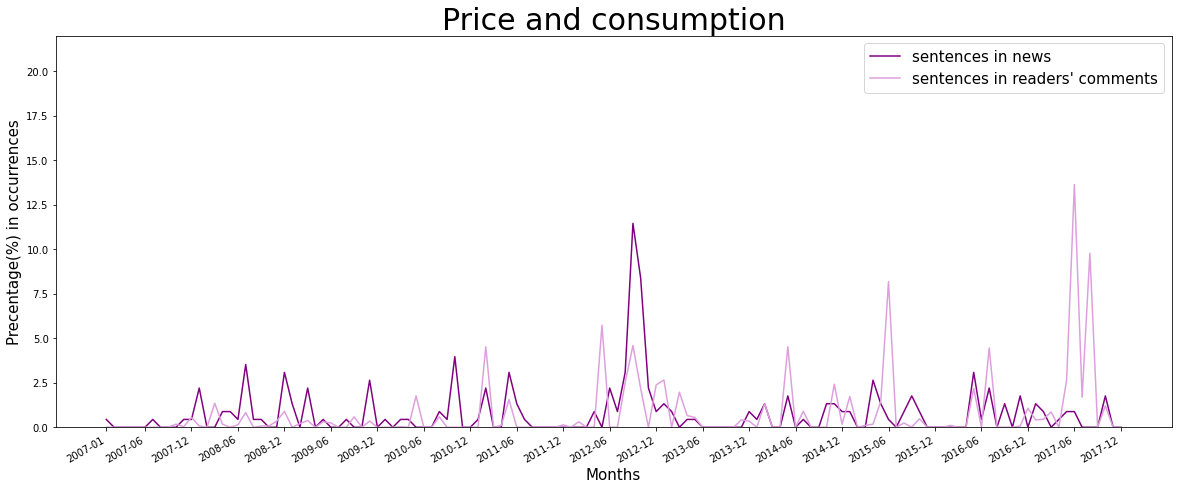

For Der Spiegel:


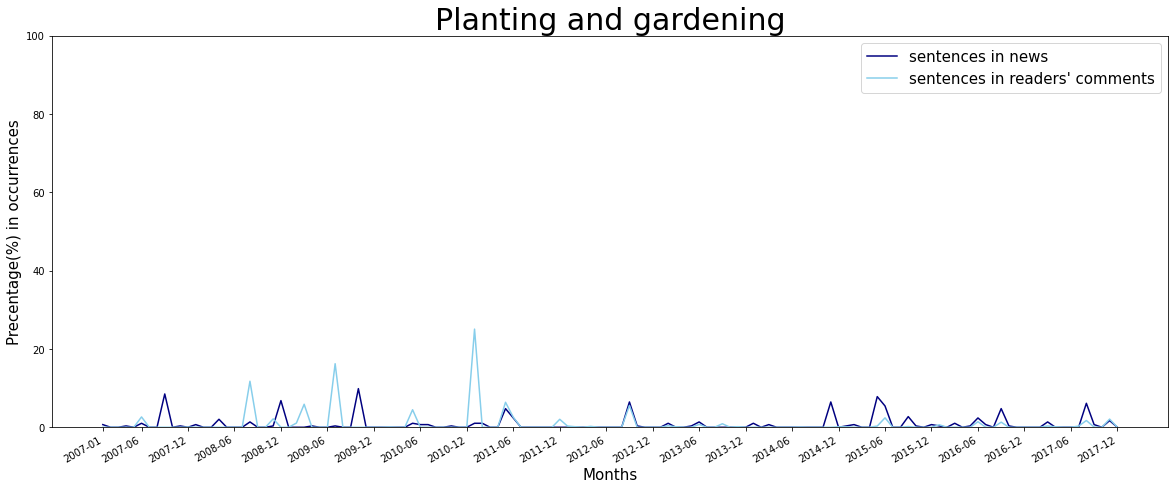

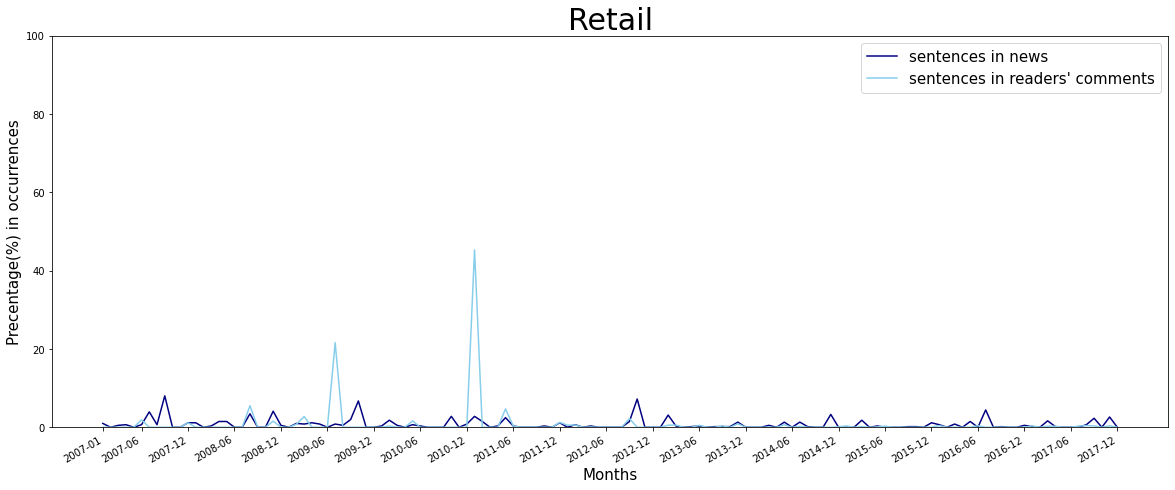

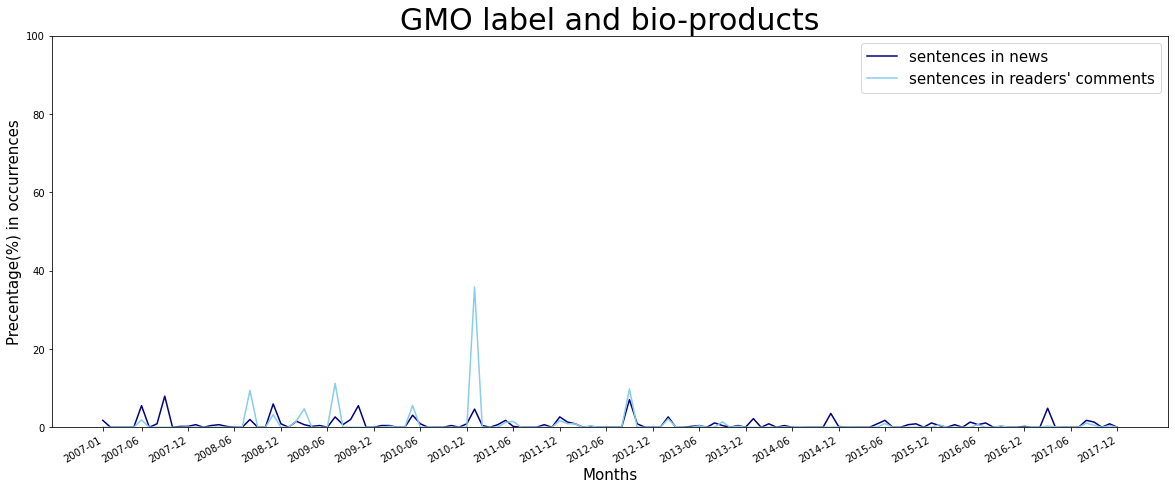

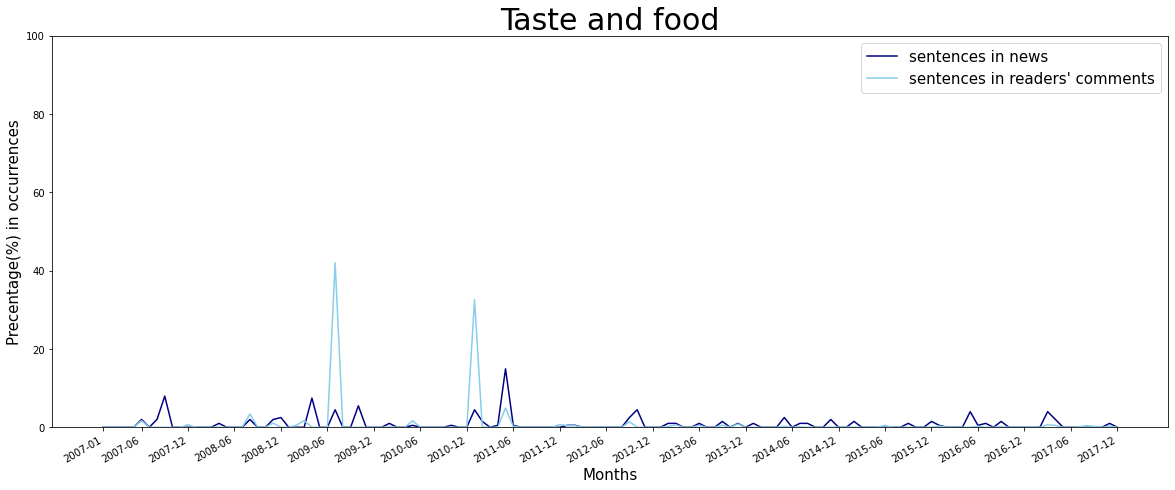

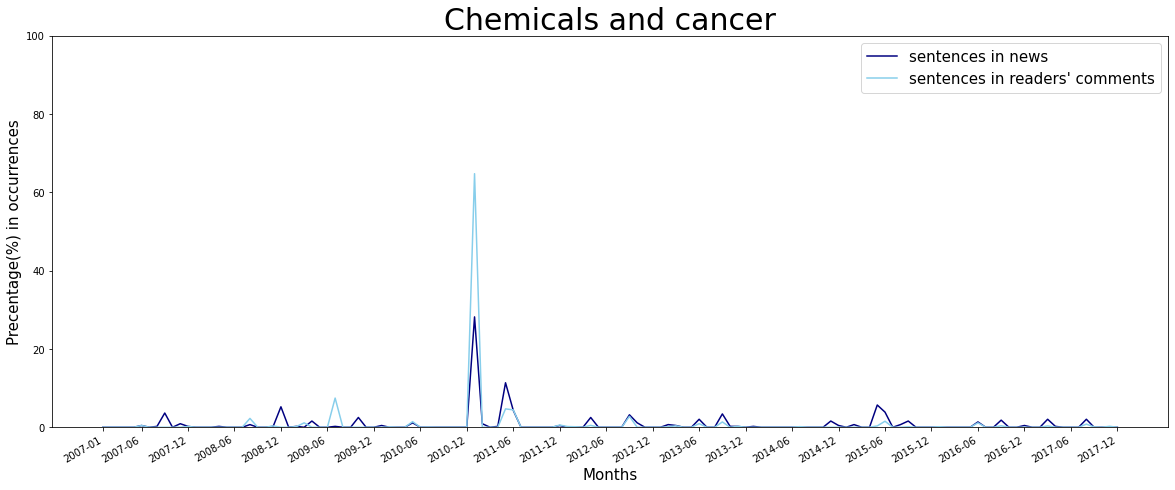

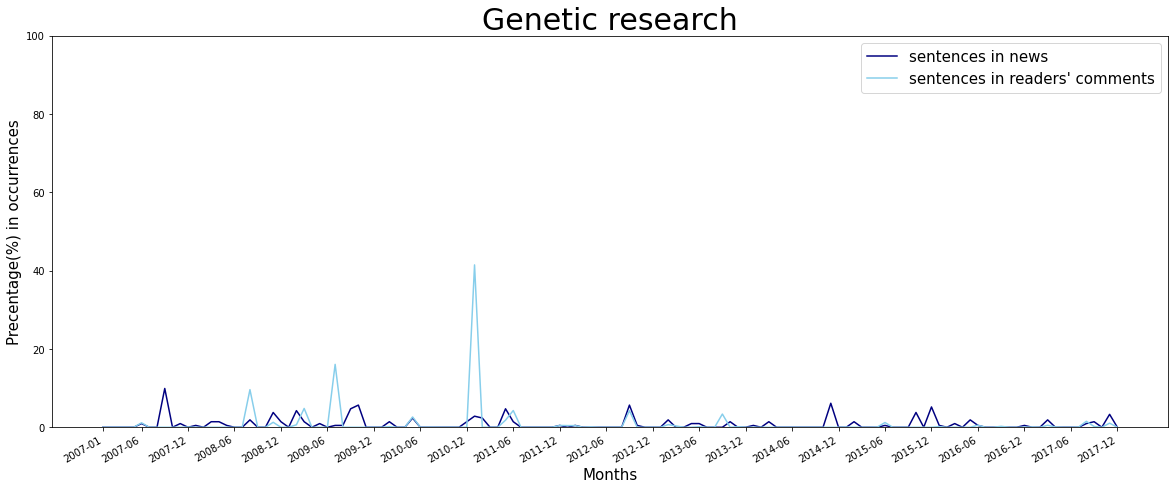

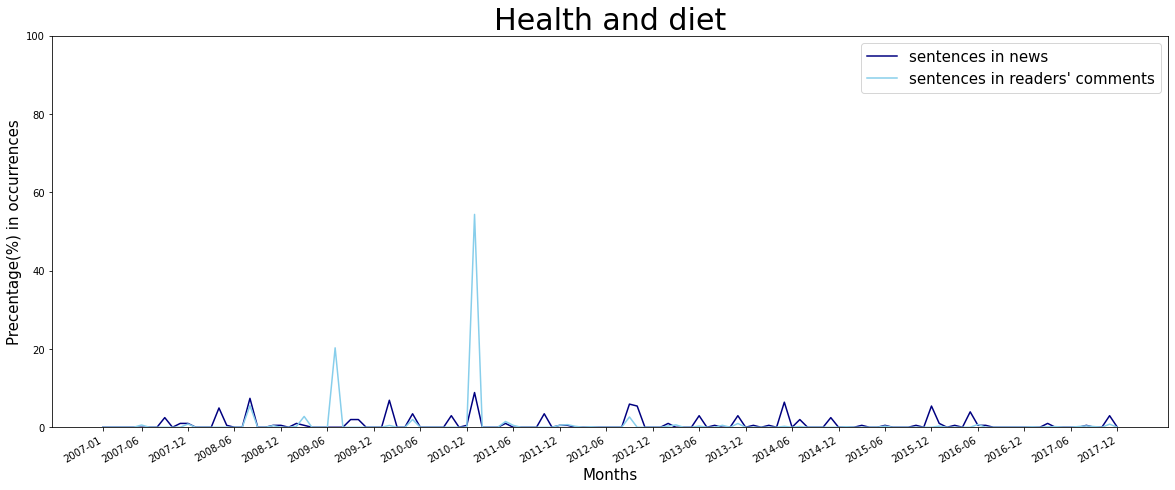

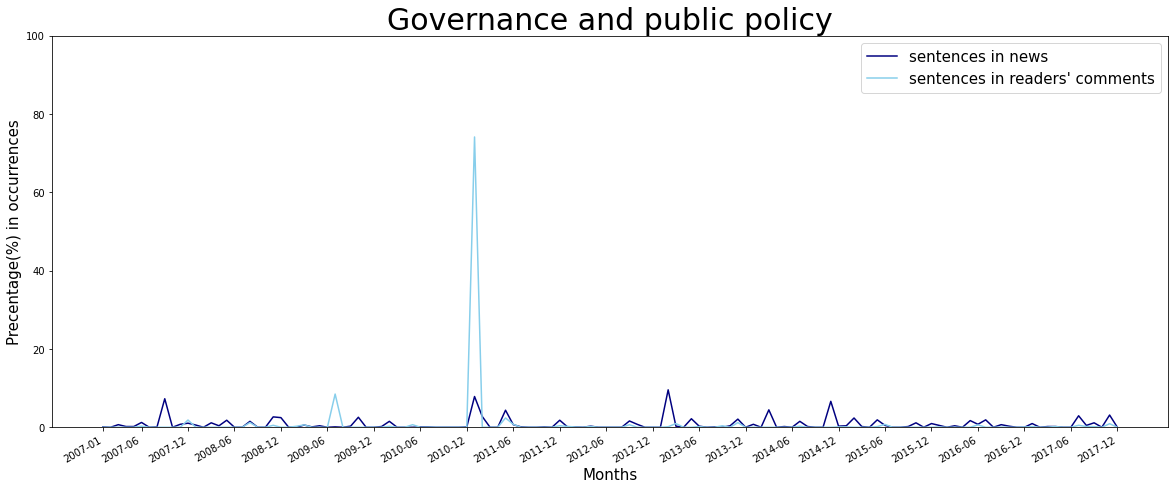

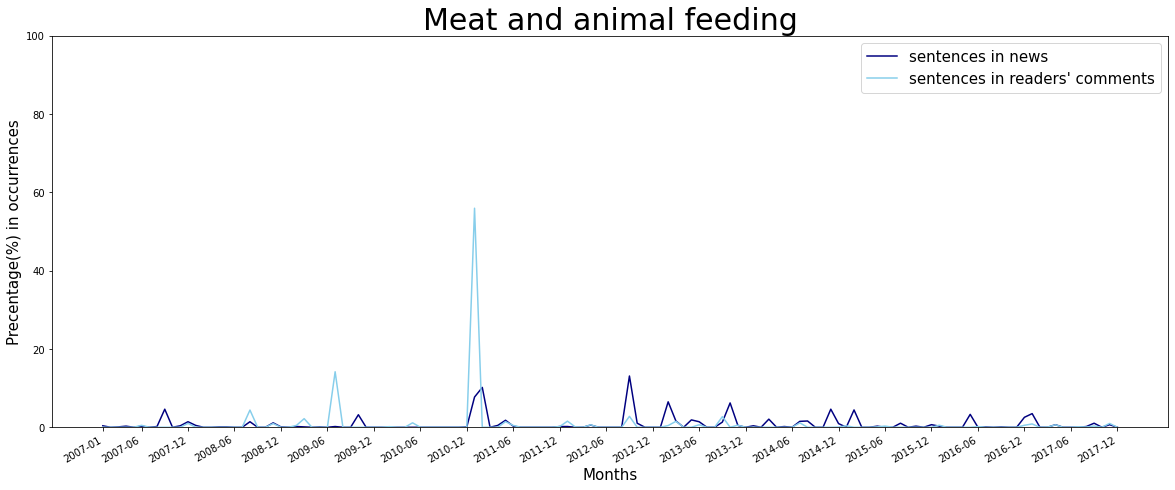

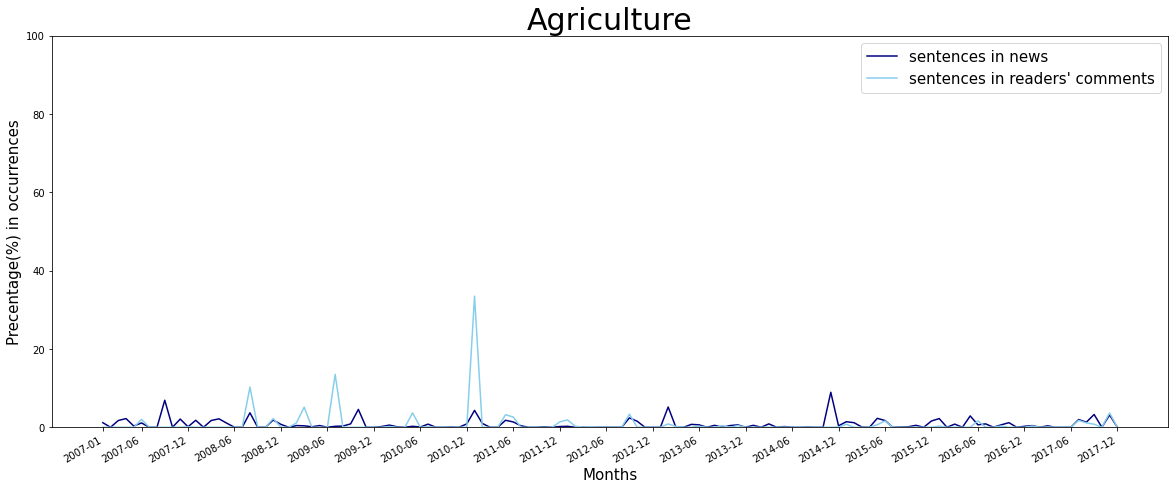

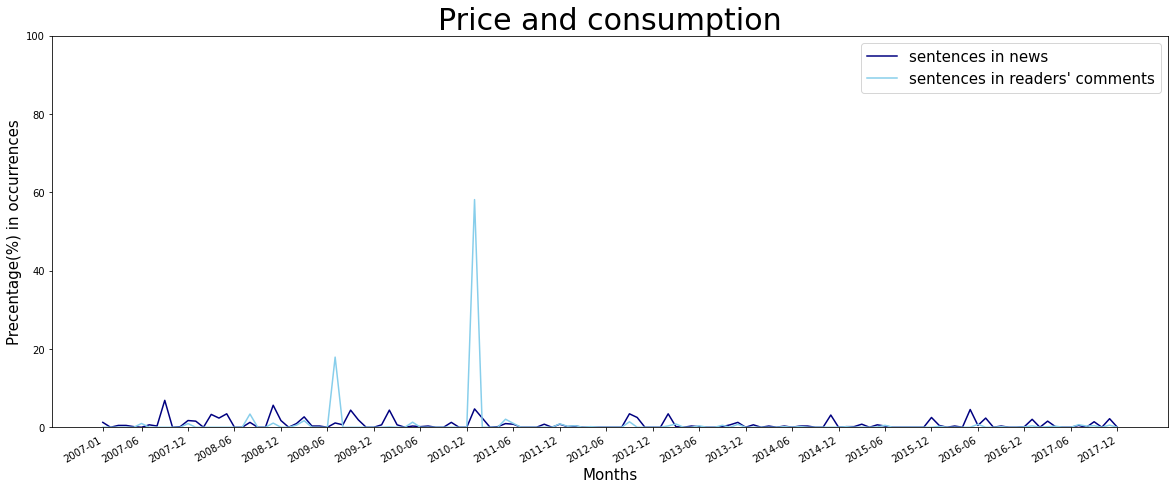

In [29]:
months, freq_nytimes_articles, freq_nytimes_comments, freq_quora_articles, freq_quora_comments, freq_spiegel_articles, freq_spiegel_comments, freq_nytimes_comments_positive, freq_nytimes_comments_neutral, freq_nytimes_comments_negative = get_sentences_counts(assignments, start_year = 2007, end_year = 2017)
xticks = ['2007-01', '2007-06', '2007-12', '2008-06', '2008-12', '2009-06', '2009-12',
          '2010-06', '2010-12', '2011-06', '2011-12', '2012-06', '2012-12',
          '2013-06', '2013-12', '2014-06', '2014-12', '2015-06', '2015-12',
          '2016-06', '2016-12', '2017-06', '2017-12']
print('For New York Times:')
get_simple_timeseries_plot('', months, freq_nytimes_articles, freq_nytimes_comments, ymax = 22, figsize = (20, 8), title_fontsize = 30, label_fontsize = 15, xticks = xticks)
print('For Der Spiegel:')
get_simple_timeseries_plot('', months, freq_spiegel_articles, freq_spiegel_comments, colors = ['navy', 'skyblue'], ymax = 100, figsize = (20, 8), title_fontsize = 30, label_fontsize = 15, xticks = xticks)